<a href="https://colab.research.google.com/github/zellning/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [12]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

- 런타임 -> 세션 다시 시작

In [11]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [ ]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304

## 12-2 CSV 형태의 데이터 수집

In [1]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230419,출발시간,0,ST-117,사직동_008_1,ST-117,사직동_008_1,1,0,0
1,20230419,출발시간,0,ST-1468,창5동_045_1,ST-1468,창5동_045_1,1,0,0
2,20230419,출발시간,0,ST-1983,신길6동_002_1,ST-1983,신길6동_002_1,1,0,0
3,20230419,출발시간,0,ST-205,도화동_037_1,ST-205,도화동_037_1,1,1,0
4,20230419,출발시간,0,ST-2075,월계3동_041_1,ST-2075,월계3동_041_1,1,0,0


In [2]:
df

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230419,출발시간,0,ST-117,사직동_008_1,ST-117,사직동_008_1,1,0,0
1,20230419,출발시간,0,ST-1468,창5동_045_1,ST-1468,창5동_045_1,1,0,0
2,20230419,출발시간,0,ST-1983,신길6동_002_1,ST-1983,신길6동_002_1,1,0,0
3,20230419,출발시간,0,ST-205,도화동_037_1,ST-205,도화동_037_1,1,1,0
4,20230419,출발시간,0,ST-2075,월계3동_041_1,ST-2075,월계3동_041_1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
7769464,20230424,도착시간,1930,ST-2504,청량리동_001_1,ST-3046,종암동_003_1,9,106,15526
7769465,20230424,출발시간,2125,ST-1370,둔촌2동_022_1,ST-2748,성내2동_026_1,10,310,17550
7769466,20230424,도착시간,2050,ST-99,자양3동_050_1,ST-99,자양3동_050_1,12,475,50399
7769467,20230424,도착시간,1220,ST-910,월곡2동_015_1,ST-655,종암동_029_1,11,81,12571


## 12-3 기초 통계량 산출

In [3]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.76947e+06 |    7.76947e+06 |  7.76947e+06 |    7.76947e+06 |      7.76947e+06 |
| mean  | 2.02304e+07 | 1451.5         |  1.07513     |   22.9326      |   2704.27        |
| std   | 8.52204     |  561.131       |  0.309264    |   31.5494      |  11951.9         |
| min   | 2.02304e+07 |    0           |  1           |    0           |      0           |
| 25%   | 2.02304e+07 | 1020           |  1           |    6           |    854           |
| 50%   | 2.02304e+07 | 1600           |  1           |   12           |   1551           |
| 75%   | 2.02304e+07 | 1855           |  1           |   27           |   2990           |
| max   | 2.02304e+07 | 2355           | 17           | 2001           |      1.29444e+07 |
범주형 데이터 요약 통계:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |

## 12-4 결측치 및 이상치 제거

In [4]:
## 결측치 제거
df = df.dropna() #null값 제거
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]
## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

In [5]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 3.50916e+06 |    3.50916e+06 |  3.50916e+06 |    3.50916e+06 |      3.50916e+06 |
| mean  | 2.02304e+07 | 1431.14        |  1.05698     |   19.996       |   2225.55        |
| std   | 8.49064     |  561.472       |  0.256897    |   21.9924      |   1901.81        |
| min   | 2.02304e+07 |    0           |  1           |    2           |     11           |
| 25%   | 2.02304e+07 | 1000           |  1           |    6           |    930           |
| 50%   | 2.02304e+07 | 1545           |  1           |   12           |   1579           |
| 75%   | 2.02304e+07 | 1845           |  1           |   25           |   2820           |
| max   | 2.02304e+07 | 2355           | 13           |  179           |   9999           |
범주형 데이터 요약 통계:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |

## 12-5 날짜/시간 데이터 형식 변환

In [6]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

In [7]:
df

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
3726,2023-04-19,출발시간,1910,ST-2011,신정6동_019_1,ST-2011,신정6동_019_1,2,2,30,수요일
4605,2023-04-19,출발시간,2200,ST-513,가양1동_049_1,ST-513,가양1동_049_1,2,2,88,수요일
10120,2023-04-19,출발시간,0,ST-1000,신정7동_003_1,ST-1977,문래동_047_1,1,43,4236,수요일
10121,2023-04-19,출발시간,0,ST-1008,신월2동_026_1,ST-1398,신정3동_066_1,1,14,2190,수요일
10122,2023-04-19,출발시간,0,ST-1010,신월3동_007_1,ST-2003,신월1동_020_1,1,7,940,수요일
...,...,...,...,...,...,...,...,...,...,...,...
7769444,2023-04-24,출발시간,1735,ST-550,잠실3동_030_2,ST-1862,잠실3동_048_1,6,53,4757,월요일
7769445,2023-04-24,출발시간,1800,ST-3225,구로1동_021_1,ST-666,구로1동_013_1,6,14,1843,월요일
7769446,2023-04-24,출발시간,1850,ST-3225,구로1동_021_1,ST-666,구로1동_013_1,6,16,2900,월요일
7769456,2023-04-24,출발시간,1810,ST-68,여의동_054_1,ST-307,신길7동_001_2,7,62,8545,월요일


## 전처리 결과 확인

In [8]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|---------------:|-------------:|---------------:|-----------------:|
| count | 3509164                       |    3.50916e+06 |  3.50916e+06 |    3.50916e+06 |      3.50916e+06 |
| mean  | 2023-04-15 16:06:59.898982656 | 1431.14        |  1.05698     |   19.996       |   2225.55        |
| min   | 2023-04-01 00:00:00           |    0           |  1           |    2           |     11           |
| 25%   | 2023-04-09 00:00:00           | 1000           |  1           |    6           |    930           |
| 50%   | 2023-04-16 00:00:00           | 1545           |  1           |   12           |   1579           |
| 75%   | 2023-04-23 00:00:00           | 1845           |  1           |   25           |   2820           |
| max   | 2023-04-30 00:00:00           | 2355           | 13           |  179           |   9999           |
| std   | nan     

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [9]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    594326
화요일    392770
수요일    446734
목요일    479264
금요일    574477
토요일    493995
일요일    527598
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

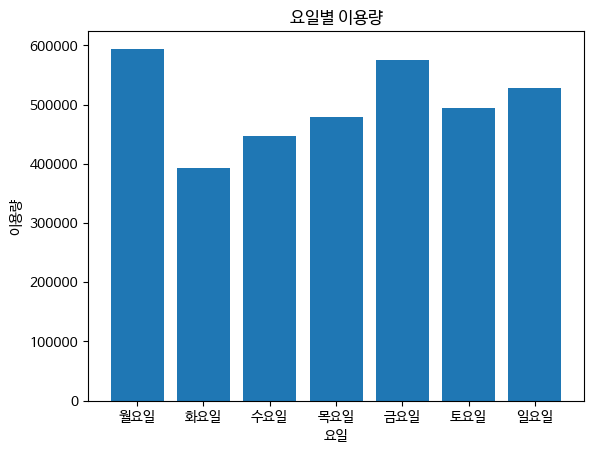

In [12]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

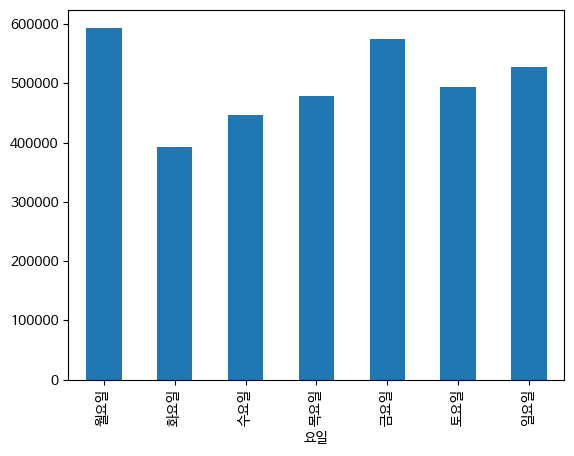

In [13]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

In [14]:
df

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
3726,2023-04-19,출발시간,1910,ST-2011,신정6동_019_1,ST-2011,신정6동_019_1,2,2,30,수요일
4605,2023-04-19,출발시간,2200,ST-513,가양1동_049_1,ST-513,가양1동_049_1,2,2,88,수요일
10120,2023-04-19,출발시간,0,ST-1000,신정7동_003_1,ST-1977,문래동_047_1,1,43,4236,수요일
10121,2023-04-19,출발시간,0,ST-1008,신월2동_026_1,ST-1398,신정3동_066_1,1,14,2190,수요일
10122,2023-04-19,출발시간,0,ST-1010,신월3동_007_1,ST-2003,신월1동_020_1,1,7,940,수요일
...,...,...,...,...,...,...,...,...,...,...,...
7769444,2023-04-24,출발시간,1735,ST-550,잠실3동_030_2,ST-1862,잠실3동_048_1,6,53,4757,월요일
7769445,2023-04-24,출발시간,1800,ST-3225,구로1동_021_1,ST-666,구로1동_013_1,6,14,1843,월요일
7769446,2023-04-24,출발시간,1850,ST-3225,구로1동_021_1,ST-666,구로1동_013_1,6,16,2900,월요일
7769456,2023-04-24,출발시간,1810,ST-68,여의동_054_1,ST-307,신길7동_001_2,7,62,8545,월요일


시간별 이용량:
 출발_시
0      77131
1      53708
2      34328
3      22495
4      17385
5      29296
6      64312
7     165864
8     253707
9     151306
10    118393
11    137690
12    155120
13    159231
14    167815
15    190808
16    236420
17    302526
18    363200
19    232469
20    184630
21    170912
22    146139
23     74279
Name: count, dtype: int64


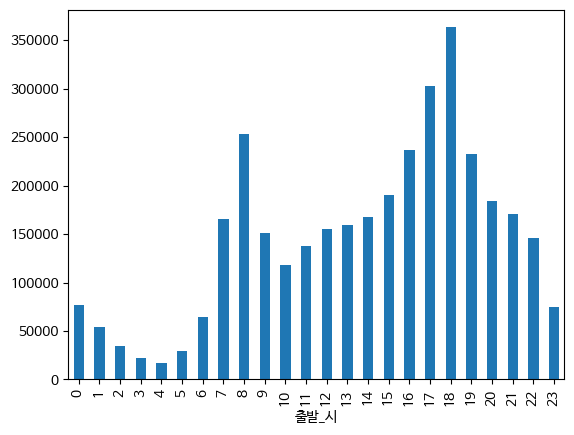

In [15]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대'] //100
## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()
## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2023-04-01    131255
2023-04-02    127850
2023-04-03    155558
2023-04-04    122686
2023-04-05     21328
2023-04-06     56926
2023-04-07    125145
2023-04-08    108558
2023-04-09    103952
2023-04-10    144229
2023-04-11     95607
2023-04-12    129586
2023-04-13    133656
2023-04-14    147609
2023-04-15     82234
2023-04-16     93039
2023-04-17    143149
2023-04-18     94659
2023-04-19    158345
2023-04-20    134882
2023-04-21    155445
2023-04-22    128175
2023-04-23    112186
2023-04-24    151390
2023-04-25     79818
2023-04-26    137475
2023-04-27    153800
2023-04-28    146278
2023-04-29     43773
2023-04-30     90571
Name: count, dtype: int64


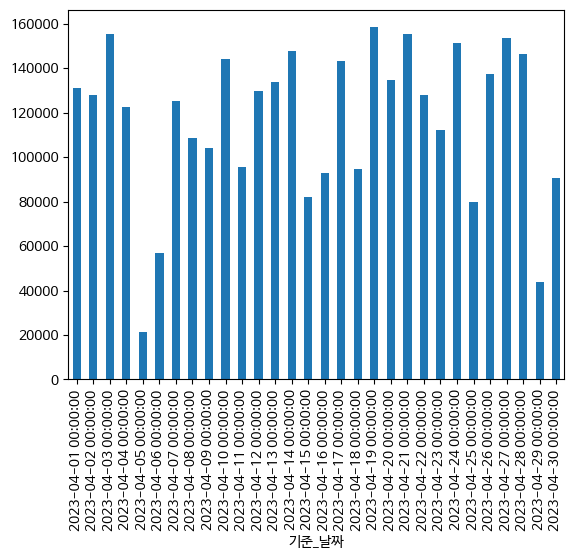

In [16]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [17]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='utf-8', skiprows=12) #skiprows=12 12줄 제외하고 나머지 가지고와라
rain_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2023-04-01,NaN,NaN,NaN,NaN
1,108,서울,2023-04-02,NaN,NaN,NaN,NaN
2,108,서울,2023-04-03,NaN,NaN,NaN,NaN
3,108,서울,2023-04-04,6.9,3.1,21:38,NaN
4,108,서울,2023-04-05,50.3,9.0,12:10,NaN


## 12-11 강수량 데이터 전처리

In [18]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

In [19]:
rain_df

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,서울,2023-04-01,0.0,NaN,NaN
1,서울,2023-04-02,0.0,NaN,NaN
2,서울,2023-04-03,0.0,NaN,NaN
3,서울,2023-04-04,6.9,3.1,21:38
4,서울,2023-04-05,50.3,9.0,12:10
5,서울,2023-04-06,2.7,1.5,19:02
6,서울,2023-04-07,0.0,NaN,NaN
7,서울,2023-04-08,0.0,NaN,NaN
8,서울,2023-04-09,0.0,NaN,NaN
9,서울,2023-04-10,0.0,NaN,NaN


## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [20]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_df의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how='left', left_on = '기준_날짜', right_on='일시')
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,131255,서울,2023-04-01,0.0,NaN,NaN
1,127850,서울,2023-04-02,0.0,NaN,NaN
2,155558,서울,2023-04-03,0.0,NaN,NaN
3,122686,서울,2023-04-04,6.9,3.1,21:38
4,21328,서울,2023-04-05,50.3,9.0,12:10


## 12-13 이용량 및 강수량 시각화

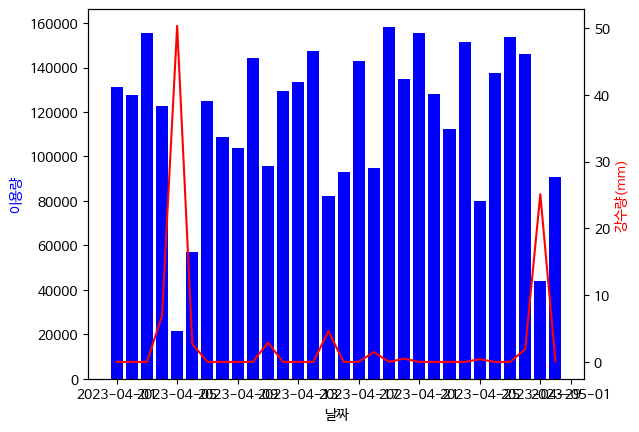

In [24]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'], color='b')
## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color='r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b') #따릉이 이용량
ax2.set_ylabel('강수량(mm)', color='r') #강수량

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.7118160250062676


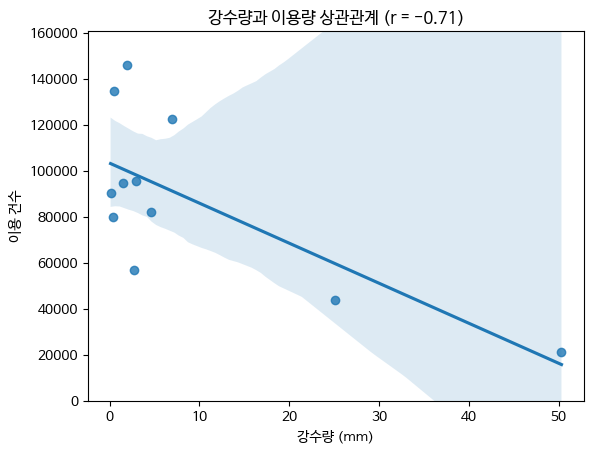

In [26]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x='강수량(mm)', y='이용량', data=merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [27]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data=merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     9.244
Date:                Fri, 21 Nov 2025   Prob (F-statistic):             0.0140
Time:                        13:22:51   Log-Likelihood:                -127.17
No. Observations:                  11   AIC:                             258.3
Df Residuals:                       9   BIC:                             259.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.034e+05   9855.144     10.494      0.0